[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy.special import expit

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
n_samples = 10**5
n_feats = 25

In [6]:
x = np.random.randn(n_samples, n_feats)
w = np.random.randn(n_feats) * 0.5
p = expit(x.dot(w))
y = np.random.binomial(1,p=p)

In [7]:
y

array([1, 1, 1, ..., 1, 1, 1])

### Simple Linear Regression check

In [8]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([-0.02315322, -0.02462007, -0.11054311,  0.00591545, -0.08040937,
        0.00545923,  0.08128487, -0.04122192, -0.0663236 ,  0.04363753,
        0.05018893,  0.11906772, -0.00142228,  0.04396228, -0.06780815,
        0.06455154, -0.01793557,  0.00704322,  0.06267878, -0.08745455,
        0.11198619,  0.03487946, -0.07341951,  0.12719622,  0.00560864])

In [9]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.43699177137829925, 0.14075180442103133)

# Regress GAN

### Define ANN Architecture

In [10]:
# Batch size during training
batch_size = 256

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [11]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [12]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [13]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [15]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, network_width, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, network_width, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [17]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/15][0/235]	Loss_D: 1.3821	Loss_G: 0.6942	D(x): 0.4989	D(G(z)): 0.4961 / 0.4998
[1/15][0/235]	Loss_D: 1.4125	Loss_G: 0.7201	D(x): 0.4796	D(G(z)): 0.4921 / 0.4867
[2/15][0/235]	Loss_D: 1.3966	Loss_G: 0.6754	D(x): 0.5045	D(G(z)): 0.5083 / 0.5095
[3/15][0/235]	Loss_D: 1.3602	Loss_G: 0.7014	D(x): 0.5127	D(G(z)): 0.4956 / 0.4978
[4/15][0/235]	Loss_D: 1.3728	Loss_G: 0.7422	D(x): 0.5056	D(G(z)): 0.4958 / 0.4800
[5/15][0/235]	Loss_D: 1.3761	Loss_G: 0.7146	D(x): 0.5027	D(G(z)): 0.4950 / 0.4914
[6/15][0/235]	Loss_D: 1.3810	Loss_G: 0.7012	D(x): 0.5069	D(G(z)): 0.5021 / 0.4975
[7/15][0/235]	Loss_D: 1.3798	Loss_G: 0.7167	D(x): 0.4965	D(G(z)): 0.4908 / 0.4903
[8/15][0/235]	Loss_D: 1.3808	Loss_G: 0.7061	D(x): 0.4955	D(G(z)): 0.4899 / 0.4959
[9/15][0/235]	Loss_D: 1.3727	Loss_G: 0.7093	D(x): 0.5057	D(G(z)): 0.4961 / 0.4938
[10/15][0/235]	Loss_D: 1.3821	Loss_G: 0.7131	D(x): 0.4915	D(G(z)): 0.4860 / 0.4922
[11/15][0/235]	Loss_D: 1.3733	Loss_G: 0.7083	D(x): 0.5054	D(G(z)): 0.49

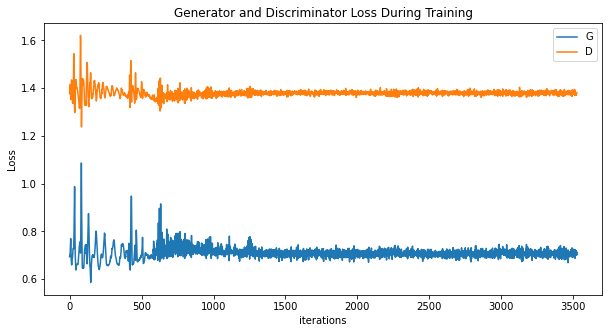

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

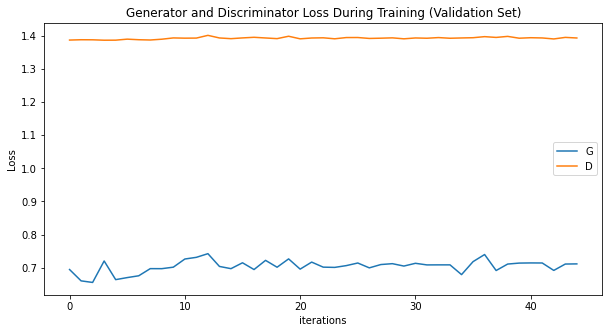

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [21]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [22]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [23]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,0.501133,0.517617
std,0.500003,0.503557
min,0.000000,-0.037473
25%,0.000000,0.016251
50%,1.000000,0.158147
75%,1.000000,1.030526
max,1.000000,1.106534


In [24]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10, duplicates="drop")
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.0385, 0.00688]",0.387333,0.000706
"(0.00688, 0.0133]",0.327000,0.010276
"(0.0133, 0.0195]",0.277333,0.016296
"(0.0195, 0.0287]",0.185500,0.023760
"(0.0287, 0.158]",0.111500,0.039242
"(0.158, 1.022]",0.615667,0.945012
"(1.022, 1.028]",0.706000,1.025522
"(1.028, 1.033]",0.790500,1.030532
"(1.033, 1.039]",0.818500,1.035891


In [25]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.25772068, 0.2500029)

In [26]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.2777419, 0.4999974)

## Test Predictions

In [27]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [28]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [29]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.493850,0.513073
std,0.499975,0.503739
min,0.000000,-0.039746
25%,0.000000,0.016150
50%,0.000000,0.055286
75%,1.000000,1.030384
max,1.000000,1.118995


In [30]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10, duplicates="drop")
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.0407, 0.0071]",0.3745,0.001125
"(0.0071, 0.0133]",0.3430,0.010287
"(0.0133, 0.0194]",0.2675,0.016207
"(0.0194, 0.0282]",0.1985,0.023396
"(0.0282, 0.0553]",0.1055,0.036511
"(0.0553, 1.022]",0.5790,0.902558
"(1.022, 1.028]",0.6955,1.025501
"(1.028, 1.033]",0.7600,1.030449
"(1.033, 1.039]",0.8140,1.035937


In [31]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.26340756, 0.24997467)

In [32]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.2829856, 0.49992436)

## Test Predictions (averaged)

In [33]:
N_SAMPLES = 1000
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [34]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.493850,0.512833
std,0.499975,0.354618
min,0.000000,-0.009402
25%,0.000000,0.162889
50%,0.000000,0.493465
75%,1.000000,0.863308
max,1.000000,1.068698


In [35]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10, duplicates="drop")
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.0104, 0.0482]",0.0200,0.033221
"(0.0482, 0.114]",0.0655,0.076402
"(0.114, 0.216]",0.1615,0.163324
"(0.216, 0.347]",0.2750,0.280580
"(0.347, 0.493]",0.3980,0.420153
"(0.493, 0.65]",0.5570,0.571846
"(0.65, 0.8]",0.7275,0.726786
"(0.8, 0.919]",0.8300,0.862429
"(0.919, 1.004]",0.9260,0.965262


In [36]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.13253303, 0.24997467)

In [37]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.2622253, 0.49992436)

# MSE model

### Define ANN Architecture

In [38]:
# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [39]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [40]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [41]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [42]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [43]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [44]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        b_size = data[0].size(0)

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = data[1]  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netG(data[0]).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     0, errG.item(), 0, 0, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    output = netG(data[0]).view(-1)

                    label = data[1] # fake labels are real for generator cost
                    errG_val = criterion(output, label)  

                    errG_vals.append(errG_val.item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
      
        iters += 1

Starting Training Loop...
[0/10][0/469]	Loss_D: 0.0000	Loss_G: 0.5044	D(x): 0.0000	D(G(z)): 0.0000 / 0.0629
[1/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1235	D(x): 0.0000	D(G(z)): 0.0000 / 0.5940
[2/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1473	D(x): 0.0000	D(G(z)): 0.0000 / 0.4584
[3/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1252	D(x): 0.0000	D(G(z)): 0.0000 / 0.4451
[4/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1118	D(x): 0.0000	D(G(z)): 0.0000 / 0.4777
[5/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1088	D(x): 0.0000	D(G(z)): 0.0000 / 0.4956
[6/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1143	D(x): 0.0000	D(G(z)): 0.0000 / 0.5280
[7/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1422	D(x): 0.0000	D(G(z)): 0.0000 / 0.5212
[8/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1087	D(x): 0.0000	D(G(z)): 0.0000 / 0.5422
[9/10][0/469]	Loss_D: 0.0000	Loss_G: 0.1294	D(x): 0.0000	D(G(z)): 0.0000 / 0.4854


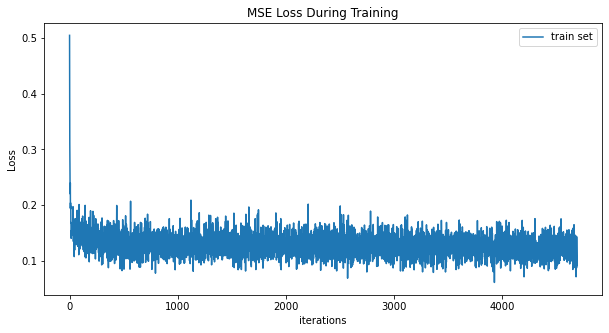

In [45]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
plt.plot(G_losses,label="train set")
# plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

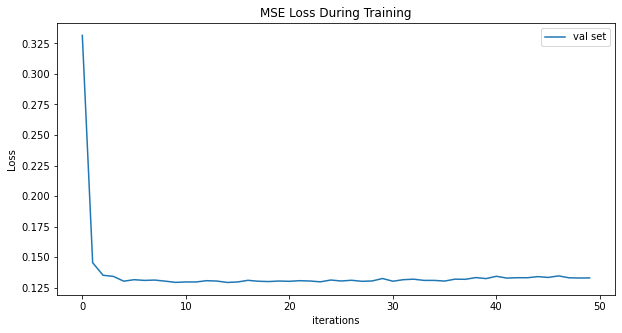

In [46]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
# plt.plot(G_losses,label="train set")
plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [47]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        fake = netG(data[0])
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [48]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [49]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,0.499367,0.505795
std,0.500004,0.373035
min,0.000000,-0.273975
25%,0.000000,0.133292
50%,0.000000,0.505164
75%,1.000000,0.874912
max,1.000000,1.377991


In [50]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10, duplicates="drop")
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.275, 0.0252]",0.011167,-0.015939
"(0.0252, 0.0901]",0.053667,0.055204
"(0.0901, 0.186]",0.122833,0.134678
"(0.186, 0.328]",0.240333,0.252483
"(0.328, 0.505]",0.402500,0.417762
"(0.505, 0.677]",0.593833,0.592497
"(0.677, 0.821]",0.747833,0.751347
"(0.821, 0.918]",0.883000,0.872836
"(0.918, 0.988]",0.953167,0.952928


In [51]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.11817855, 0.25000378)

In [52]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.24212633, 0.4999992)

## Test Predictions

In [53]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        gen_ip = data[0] 
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [54]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [55]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.501950,0.505701
std,0.500009,0.372220
min,0.000000,-0.293254
25%,0.000000,0.132883
50%,1.000000,0.505229
75%,1.000000,0.870885
max,1.000000,1.385318


In [56]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10, duplicates="drop")
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.294, 0.0253]",0.0335,-0.017096
"(0.0253, 0.0897]",0.0670,0.056435
"(0.0897, 0.186]",0.1505,0.134915
"(0.186, 0.333]",0.2815,0.256454
"(0.333, 0.505]",0.4455,0.419408
"(0.505, 0.674]",0.5995,0.592074
"(0.674, 0.815]",0.7245,0.748298
"(0.815, 0.915]",0.8425,0.868346
"(0.915, 0.989]",0.9200,0.952797


In [57]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.137054, 0.2500087)

In [58]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.26165348, 0.49999243)

# Gaussian Process Regression

In [59]:
model = GaussianProcessRegressor(
    kernel=kernels.RBF(length_scale=0.05)
    ,n_restarts_optimizer=10
).fit(x[val], y[val])

In [60]:
model.kernel_.get_params()

{'length_scale': 2.909804172595744, 'length_scale_bounds': (1e-05, 100000.0)}

In [61]:
y_pred_gauss = model.predict(x[test])
y_true_gauss = y[test]
y_pred_gauss.mean(), y_true_gauss.mean(), y_pred_gauss.std(), y_true_gauss.std()

(0.4900941324462723, 0.50195, 0.43513950185119143, 0.4999961974855409)

In [62]:
mean_absolute_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )
).mean()

(0.36379706633345177, 0.49999239500000003)

In [63]:
mean_squared_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )**2
).mean()

(0.2114516888868636, 0.24999619750000002)